# Plot SST Predictions

Plots results of "CNN_test_lead_ann.py" script, which used a CNN to predict AMV at various lead times (0-24) for a combination of predictors.


In [1]:
import matplotlib.pyplot as plt
import numpy as np


## User Edits

In [2]:
# Paths
datpath = "/Users/gliu/Downloads/2020_Fall/6.862/Project/CESM_data/Metrics/" # path to the data
outpath = "/Users/gliu/Downloads/2020_Fall/6.862/Project/Figures/" # output directory

# Experiment parameters
leadtime   = 25  # Lead time in months (include lag 0)
num_epochs = 10   # Number of Epochs tested for
nmembers   = 40   # Total number of ensemble members used 
netname    = 'CNN2' # Network Type [CNN1,CNN2,FNN,LR]
netlong    = "2-Layer CNN (CNN2)" # Network Long Name
season     = 'Ann'
resolution = '2deg'
indexregion = 'NAT'

# Save Figures? (Set to True to save to outpath)
savefigures = True

# Set variable names
varnames = ["SST","SSS","PSL","ALL"]

In [3]:
def calc_AMV_index(region,invar,lat,lon):
    """
    Select bounding box for a given AMV region for an input variable
        "SPG" - Subpolar Gyre
        "STG" - Subtropical Gyre
        "TRO" - Tropics
        "NAT" - North Atlantic
    
    Parameters
    ----------
    region : STR
        One of following the 3-letter combinations indicating selected region
        ("SPG","STG","TRO","NAT")
        
    var : ARRAY [Ensemble x time x lat x lon]
        Input Array to select from
    lat : ARRAY
        Latitude values
    lon : ARRAY
        Longitude values    

    Returns
    -------
    amv_index [ensemble x time]
        AMV Index for a given region/variable

    """
    
    # Select AMV Index region
    bbox_SP = [-60,-15,40,65]
    bbox_ST = [-80,-10,20,40]
    bbox_TR = [-75,-15,0,20]
    bbox_NA = [-80,0 ,0,65]
    regions = ("SPG","STG","TRO","NAT")        # Region Names
    bboxes = (bbox_SP,bbox_ST,bbox_TR,bbox_NA) # Bounding Boxes
    
    # Get bounding box
    bbox = bboxes[regions.index(region)]
    
    # Select Region
    selvar = invar.copy()
    klon = np.where((lon>=bbox[0]) & (lon<=bbox[1]))[0]
    klat = np.where((lat>=bbox[2]) & (lat<=bbox[3]))[0]
    selvar = selvar[:,:,klat[:,None],klon[None,:]]
    
    # Take mean ove region
    amv_index = np.nanmean(selvar,(2,3))
    
    return amv_index

## Load data

In [4]:
%%time
# Load results from CNN lead experiments 

# Set up experiment identifier (ex: CNN2_nepoch10_nens42_lead24)
expname = "%s%s_%s_%s_nepoch%02i_nens%02i_lead%02i" % (season,resolution,indexregion,netname,num_epochs,nmembers,leadtime-1)
print("Loading experiment: %s"%expname)

# Preallocate
nvars = len(varnames)
train_loss = np.zeros((nvars,num_epochs,leadtime)) # [variable x epoch x leadtime]
test_loss  = np.zeros(train_loss.shape) # [variable x epoch x leadtime]
test_corr    = np.zeros((nvars,leadtime)) # [variable x leadtime]
train_corr   = np.zeros(test_corr.shape) # [variable x leadtime]

for v,vname in enumerate(varnames):
    vname = varnames[v]

    # Load NPZ file
    results = np.load("%sleadtime_testing_%s_%s.npz"%(datpath,vname,expname))

    # Get correlation for train and test (note, need to rename arrays in future...)
    train_loss[v,:,:] = results['train_loss'].copy() # [n_epochs,lead]
    test_loss[v,:,:] = results['test_loss'].copy()  # [n_epochs,lead] 
    test_corr[v,:] = results['test_corr'].copy()  # [lead,]
    train_corr[v,:] = results['train_corr'].copy() # [lead,]
    
    print("Loaded %s"%vname)


Loading experiment: Ann2deg_NAT_CNN2_nepoch10_nens40_lead24
Loaded SST
Loaded SSS
Loaded PSL
Loaded ALL
CPU times: user 8.58 ms, sys: 2.3 ms, total: 10.9 ms
Wall time: 11.8 ms


In [5]:
# Load SST autocorrelation for comparison
# sst_auto = np.load("../../CESM_Data/SST_autocorrelation_detrended0_latweight1.npy") # [Ensemble x Lag]
# sst_auto.shape

# Or calculate sst auto on the spot...
sst_normed = np.load('../../CESM_data/CESM_sst_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))
sst_ensemble = calc_AMV_index(indexregion,sst_normed[:,:,:,:],lat,lon)

# Calculate Autocorrelation
tstep = 86
lags  = 25
sst_lagged_corr = np.zeros((nmembers,lags))
#sss_lagged_corr = np.zeros((42,lags))

for lead in range(lags):
    sst_lead = sst_ensemble[:,lead:]
    sst_lag = sst_ensemble[:,0:tstep-lead]
    #sss_lag = sss_ensemble[:,0:tstep-lead]
    
    for ien in range(nmembers):
        sst_lagged_corr[ien,lead] = np.corrcoef( sst_lead[ien,:],sst_lag[ien,:] )[0,1]
        #sss_lagged_corr[ien,lead] = np.corrcoef( sst_lead[ien,:],sss_lag[ien,:] )[0,1]
sst_auto = sst_lagged_corr.copy()

## Make Plots

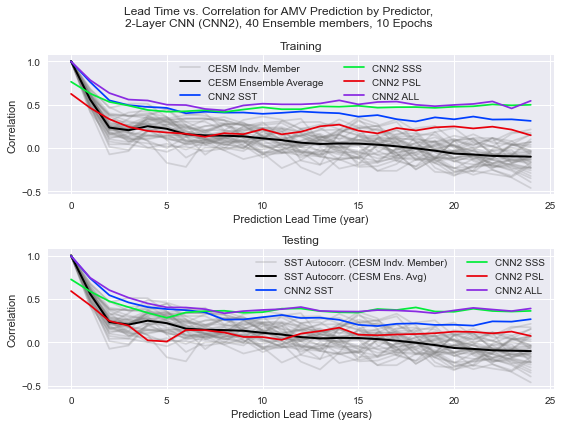

In [7]:
# Plot Lead Time Correlation
fig,axs = plt.subplots(2,1,sharey=True,figsize=(8,6))
plt.style.use('seaborn')
plt.style.use('seaborn-bright')

# Plot for training set
ax = axs[0]
for ien in range(nmembers): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")
for v in range(nvars): # Plot CNN Results
    ax.plot(train_corr[v,:],label=netname + " " + varnames[v])
ax.legend(ncol=2)  
ax.set_title("Training")
ax.set_ylabel("Correlation")
ax.set_xlabel("Prediction Lead Time (year)")

# plot for testing set
ax = axs[1]
for ien in range(nmembers): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="SST Autocorr. (CESM Indv. Member)")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="SST Autocorr. (CESM Ens. Avg)")
for v in range(nvars):
    ax.plot(test_corr[v,:],label=netname + " " + varnames[v])
ax.legend(ncol=2)
ax.set_title("Testing")
ax.set_ylabel("Correlation")
ax.set_xlabel("Prediction Lead Time (years)")

# title and layout formatting
plt.suptitle("Lead Time vs. Correlation for AMV Prediction by Predictor,\n" + 
             "%s, %s Ensemble members, %s Epochs"%(netlong,nmembers,num_epochs))
plt.tight_layout()
if savefigures:
    plt.savefig("%sCorrelation_vs_Leadtime_%s.png"%(outpath,expname),dpi=200)

plt.style.use('seaborn-bright')

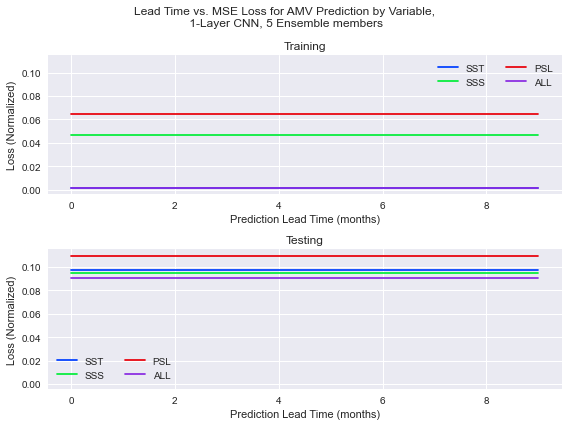

In [40]:
# Plot Losses for each set/variable
fig,axs = plt.subplots(2,1,sharey=True,figsize=(8,6))
plt.style.use('seaborn-bright')

ax = axs[0]
for v in range(nvars):
    ax.plot(train_loss[v,:,:].min(1),label=varnames[v]) # Take minimum loss for all epochs
ax.legend(ncol=2)  
ax.set_title("Training")
ax.set_xlabel("Prediction Lead Time (months)")
ax.set_ylabel("Loss (Normalized)")

ax = axs[1]
for v in range(nvars):
    ax.plot(test_loss[v,:,:].mean(1),label=varnames[v])
ax.legend(ncol=2)
ax.set_title("Testing")
ax.set_ylabel("Loss (Normalized)")
ax.set_xlabel("Prediction Lead Time (months)")

plt.suptitle("Lead Time vs. MSE Loss for AMV Prediction by Variable,\n 1-Layer CNN, 5 Ensemble members")
plt.tight_layout()

if savefigures:
    plt.savefig("%sMSELoss_vs_Leadtime_%s.png"%(outpath,expname),dpi=200)

Text(0.5, 1.0, 'Comparing Dataset size')

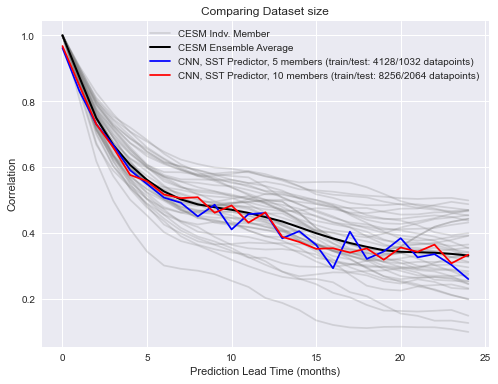

In [96]:
# Compare the result for training for different number of ensembles (10 versus 5)
# Note: this section is obsolete due to change in the experiment naming convention
result10 = np.load("%sleadtime_testing_SST_nens10.npz"%datpath)
train_loss10 = result10['arr_0'].copy() 
test_loss10 = result10['arr_1'].copy()  
test_corr10 = result10['arr_2'].copy()  
train_corr10 = result10['arr_3'].copy() 

# Plot for testing set
fig,ax = plt.subplots(1,1,sharey=True,figsize=(8,6))
plt.style.use('seaborn-bright')
for ien in range(42): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")

ax.plot(test_corr[0,:],label="CNN, SST Predictor, 5 members (train/test: %i/%i datapoints)"%(np.fix(1032*5*.8),np.fix(1032*5*.2)),color='b')
ax.plot(test_corr10[:],label="CNN, SST Predictor, 10 members (train/test: %i/%i datapoints)"%(np.fix(1032*10*.8),np.fix(1032*10*.2)),color='r')

ax.legend()

ax.set_xlabel("Prediction Lead Time (months)")
ax.set_ylabel("Correlation")
ax.set_title("Comparing Dataset size")

Text(0.5, 1.0, 'Comparing Dataset size for AMV Prediction, Predictor = SST')

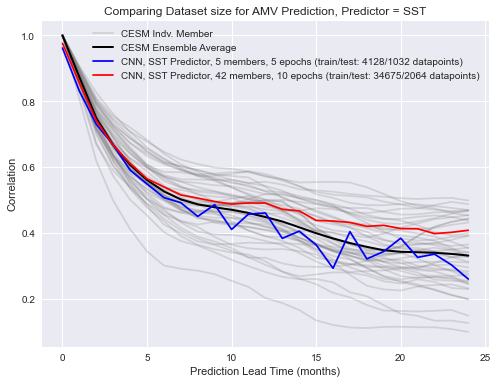

In [119]:
# Compare the result for training for full dataset
vname = 'SST'
vn = varnames.index(vname)


result10 = np.load("%s/1_layer_CNN_All_Data/leadtime_testing_%s_epochs10_nens42.npz"%(datpath,vname))
train_loss10 = result10['arr_0'].copy() 
test_loss10 = result10['arr_1'].copy()  
test_corr10 = result10['arr_2'].copy()  
train_corr10 = result10['arr_3'].copy() 

# Plot for testing set
fig,ax = plt.subplots(1,1,sharey=True,figsize=(8,6))
plt.style.use('seaborn-bright')
for ien in range(42): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")

ax.plot(test_corr[vn,:],label="CNN, %s Predictor, 5 members, 5 epochs (train/test: %i/%i datapoints)"%(vname,np.fix(1032*5*.8),np.fix(1032*5*.2)),color='b')
ax.plot(test_corr10[:],label="CNN, %s Predictor, 42 members, 10 epochs (train/test: %i/%i datapoints)"%(vname,np.fix(1032*42*.8),np.fix(1032*10*.2)),color='r')

ax.legend()

ax.set_xlabel("Prediction Lead Time (months)")
ax.set_ylabel("Correlation")
ax.set_title("Comparing Dataset size for AMV Prediction, Predictor = %s"% (vname))

In [108]:
vname = 'SST'
vn = varnames.index(vname)
vn

0

/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


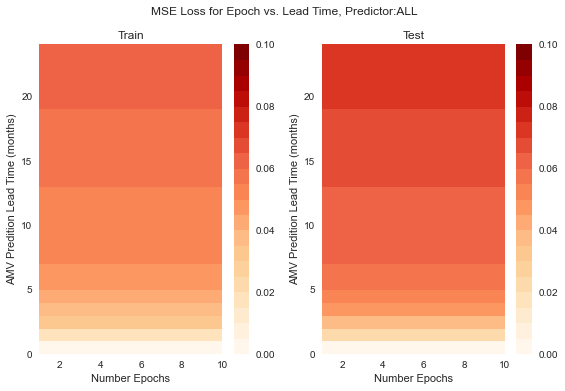

In [186]:
# Plot MSE Loss for Epoch vs Lead time

vname = 'ALL' # Select varable
vn = varnames.index(vname)

# Make plotting values
pepochs = np.arange(1,num_epochs+1,1)
pleads  = np.arange(0,leadtime,1)


fig,axs = plt.subplots(1,2)
cmap = plt.get_cmap('OrRd',20)
plt.style.use('seaborn')

# Plot Train
ax = axs[0]
plotvar = train_loss[v,:,:]
plt.style.use('seaborn')
cmap = plt.get_cmap('OrRd',20)
pcm1 = ax.pcolormesh(pepochs,pleads,plotvar.T,vmin=0,vmax=0.10,cmap=cmap)
fig.colorbar(pcm1,ax=ax)
ax.set_xlabel("Number Epochs")
ax.set_ylabel("AMV Predition Lead Time (months)")
ax.set_title("Train")

# Plot Test
ax = axs[1]
plotvar = test_loss[v,:,:]
pcm2 = ax.pcolormesh(pepochs,pleads,plotvar.T,vmin=0,vmax=0.10,cmap=cmap)
fig.colorbar(pcm2,ax=ax)
ax.set_xlabel("Number Epochs")
ax.set_ylabel("AMV Predition Lead Time (months)")
ax.set_title("Test")
plt.suptitle("MSE Loss for Epoch vs. Lead Time, Predictor:%s"%vname)

plt.tight_layout()

if savefigures:
    plt.savefig("%sMSELoss_Epoch_vs_Leadtime%i_%s_%iepochs_%imembers.png"%(outpath,leadtime,vname,num_epochs,nmembers),dpi=200)
    


In [150]:
outpath

'/Users/gliu/Downloads/2020_Fall/6.862/Project/Figures/'

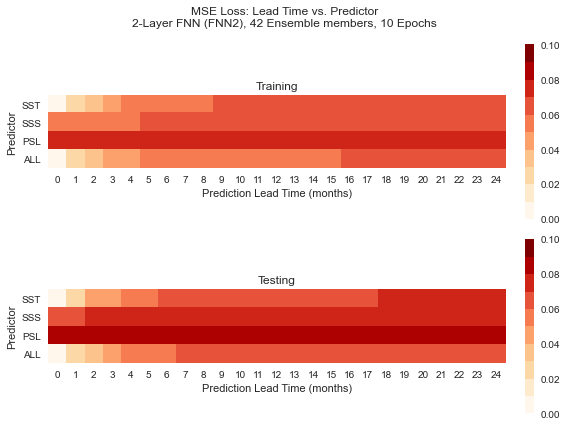

In [251]:
# Plot MSE Losses, variable versus lead time
fig,axs = plt.subplots(2,1,sharey=True,figsize=(8,6))
plt.style.use('seaborn-bright')
cmap = plt.get_cmap('OrRd',10)
pleads  = np.arange(0,leadtime,1)
vmin = 0
vmax = 0.1

ax = axs[0]
pcm1 =ax.imshow(train_loss[:,:,:].min(1),vmin=vmin,vmax=vmax,cmap=cmap) # Take minimum loss for all epochs
ax.set_xticks(np.arange(0,leadtime,1))
ax.set_yticks(np.arange(0,len(varnames),1))
ax.set_xticklabels(pleads)
ax.set_yticklabels(varnames)
ax.grid(linestyle="")
ax.set_title("Training")
ax.set_xlabel("Prediction Lead Time (months)")
ax.set_ylabel("Predictor")
fig.colorbar(pcm1,ax=ax,fraction=0.046,pad=0.04)

ax = axs[1]
pcm2 =ax.imshow(test_loss[:,:,:].min(1),vmin=vmin,vmax=vmax,cmap=cmap) # Take minimum loss for all epochs
ax.set_xticks(np.arange(0,leadtime,1))
ax.set_yticks(np.arange(0,len(varnames),1))
ax.set_xticklabels(pleads)
ax.set_yticklabels(varnames)
ax.grid(linestyle="")
ax.set_title("Testing")
ax.set_xlabel("Prediction Lead Time (months)")
ax.set_ylabel("Predictor")
fig.colorbar(pcm2,ax=ax,fraction=0.046,pad=0.04)

plt.suptitle("MSE Loss: Lead Time vs. Predictor\n" + 
            "%s, %s Ensemble members, %s Epochs"%(netlong,nmembers,num_epochs))
plt.tight_layout()

if savefigures:
     plt.savefig("%sMSELoss_Predictor_vs_Leadtime_%s.png"%(outpath,expname),dpi=200)

## Load in another experiment to compare with CNN Results



In [9]:
%%time

# Indicate Experiment name and settings
leadtime    = 25  # Lead time in months (include lag 0)
num_epochs  = 10   # Number of Epochs tested for
nmembers    = 40   # Total number of ensemble members used 
netname2    = 'FNN2' # Network Type [CNN1,CNN2,FNN,LR]
netlong2    = "2-Layer FNN (FNN2)" # Network Long Name

# Set up experiment identifier (ex: CNN2_nepoch10_nens42_lead24)
#expname2 = "%s_nepoch%02i_nens%02i_lead%02i" % (netname2,num_epochs,nmembers,leadtime-1)
expname2 = "%s%s_%s_%s_nepoch%02i_nens%02i_lead%02i" % (season,resolution,indexregion,netname2,num_epochs,nmembers,leadtime-1)

print("Loading experiment: %s"%expname2)

# Preallocate
nvars = len(varnames)
train_loss2 = np.zeros((nvars,num_epochs,leadtime)) # [variable x epoch x leadtime]
test_loss2  = np.zeros(train_loss.shape) # [variable x epoch x leadtime]
test_corr2    = np.zeros((nvars,leadtime)) # [variable x leadtime]
train_corr2   = np.zeros(test_corr.shape) # [variable x leadtime]

for v,vname in enumerate(varnames):
    vname = varnames[v]

    # Load NPZ file
    results = np.load("%sleadtime_testing_%s_%s.npz"%(datpath,vname,expname2))

    # Get correlation for train and test (note, need to rename arrays in future...)
    train_loss2[v,:,:] = results['train_loss'].copy() # [n_epochs,lead]
    test_loss2[v,:,:] = results['test_loss'].copy()  # [n_epochs,lead] 
    test_corr2[v,:] = results['test_corr'].copy()  # [lead,]
    train_corr2[v,:] = results['train_corr'].copy() # [lead,]
    
    print("Loaded %s"%vname)


Loading experiment: Ann2deg_NAT_FNN2_nepoch10_nens40_lead24
Loaded SST
Loaded SSS
Loaded PSL
Loaded ALL
CPU times: user 6.85 ms, sys: 1.8 ms, total: 8.65 ms
Wall time: 9.52 ms


In [10]:
## Load in ResNet50 Results
respath = "/Users/gliu/Downloads/2020_Fall/6.862/Project/CESM_data/proc/ResNet50_Test/"
loaded = np.load(respath+"leadtime_testing_ALL_RN50_nepoch01_nens01_lead24_ALL.npz")

train_loss_r = loaded['train_loss']
test_loss_r  = loaded['test_loss']
train_corr_r = loaded['train_corr']
test_corr_r  = loaded['test_corr']


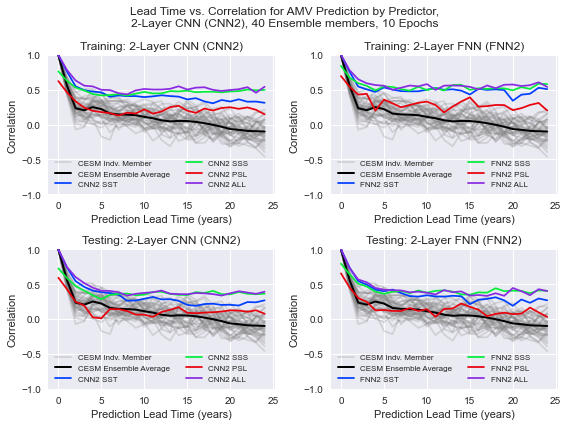

In [11]:
# Plot Lead Time Correlation (4x4 Grid)
plotres = False

fig,axs = plt.subplots(2,2,sharey=False,figsize=(8,6))
plt.style.use('seaborn-bright')

def plot_corrleadtime(invar,nvars,sst_auto,netname,title,nmembers=40,ax=None):
    """
    Make a line plot comparing predictors for a given NN
    """
    
    if ax is None:
        ax.gca()
    for ien in range(nmembers): # Plot CESM Reults
        ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
    ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
    ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")
    for v in range(nvars): # Plot CNN Results
        ax.plot(invar[v,:],label=netname + " " + varnames[v])
    ax.legend(ncol=2,fontsize=8)  
    ax.set_title(title)
    ax.set_ylabel("Correlation")
    ax.set_ylim([-1,1])
    ax.set_xlabel("Prediction Lead Time (years)")
    return ax

# Plot for training set
ax = axs[0,0]
if plotres:
    ax.plot(test_corr_r ,label="ResNet50 (1-ens)",color='m')
ax = plot_corrleadtime(train_corr,nvars,sst_auto,netname,"Training: %s"%(netlong),ax=ax)

ax = axs[1,0]
if plotres:
    ax.plot(test_corr_r ,label="ResNet50 (1-ens)",color='m')
ax = plot_corrleadtime(test_corr,nvars,sst_auto,netname,"Testing: %s"%(netlong),ax=ax)

ax = axs[0,1]
if plotres:
    ax.plot(test_corr_r ,label="ResNet50 (1-ens)",color='m')
ax = plot_corrleadtime(train_corr2,nvars,sst_auto,netname2,"Training: %s"%(netlong2),ax=ax)

ax = axs[1,1]
if plotres:
    ax.plot(test_corr_r ,label="ResNet50 (1-ens)",color='m')
ax = plot_corrleadtime(test_corr2,nvars,sst_auto,netname2,"Testing: %s"%(netlong2),ax=ax)

# title and layout formatting
plt.suptitle("Lead Time vs. Correlation for AMV Prediction by Predictor,\n" + 
             "%s, %s Ensemble members, %s Epochs"%(netlong,nmembers,num_epochs))

plt.tight_layout()
if savefigures:
    plt.savefig("%sCorrelation_vs_Leadtime_%s_vs_%s.png"%(outpath,expname,expname2),dpi=200)

In [246]:
netname,netname2

('CNN2', 'FNN2')

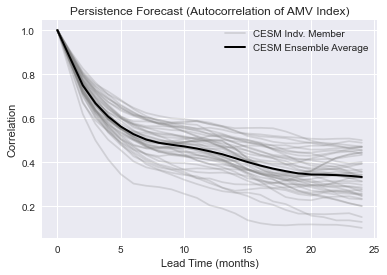

In [257]:
# Just plot the SST Autocorrelation
result10 = np.load("%sleadtime_testing_SST_nens10.npz"%datpath)
train_loss10 = result10['arr_0'].copy() 
test_loss10 = result10['arr_1'].copy()  
test_corr10 = result10['arr_2'].copy()  
train_corr10 = result10['arr_3'].copy() 

# Plot for testing set
fig,ax = plt.subplots(1,1,sharey=True,figsize=(6,4))
plt.style.use('seaborn-bright')
for ien in range(42): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")

ax.legend()
ax.set_xlabel("Lead Time (months)")
ax.set_ylabel("Correlation")
ax.set_title("Persistence Forecast (Autocorrelation of AMV Index)")

if savefigures:
    plt.savefig("%sAutocorrelation_CESM.png"%(outpath),dpi=200)

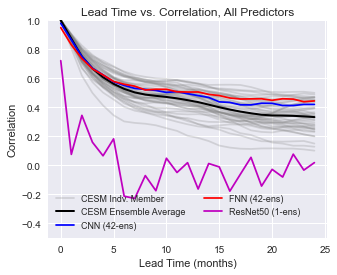

In [56]:
# Combine informtaion in a single plot

# Plot for testing set
fig,ax = plt.subplots(1,1,sharey=True,figsize=(5,4))
plt.style.use('seaborn-bright')
for ien in range(42): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")
ax.plot(test_corr[-1,:],label="CNN (42-ens)",color='blue')
ax.plot(test_corr2[-1,:],label="FNN (42-ens)",color='red')
ax.plot(test_corr_r,label="ResNet50 (1-ens)",color='m')

ax.legend(ncol=2,fontsize=9)
ax.set_xlabel("Lead Time (months)")
ax.set_ylabel("Correlation")
ax.set_ylim([-.5,1])
ax.set_title("Lead Time vs. Correlation, All Predictors")

if savefigures:
    plt.savefig("%sCompare_Networks.png"%(outpath),dpi=200)

In [57]:
# Compare the case where everything has only been trained for 1 epoch

# Load CNN Results
path = "/Users/gliu/Downloads/2020_Fall/6.862/Project/CESM_data/proc/LeadTesting/"
loadcnn = np.load(path+"leadtime_testing_ALL_CNN2_nepoch01_nens01_lead24.npz")
cnncorr = loadcnn['test_corr'].copy()

# Load FNN Results
loadfnn = np.load(path+"leadtime_testing_ALL_FNN2_nepoch01_nens01_lead24.npz")
fnncorr = loadfnn['test_corr'].copy()


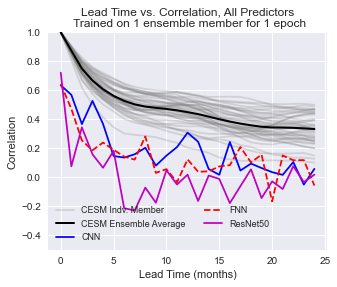

In [65]:
# Same plot as above bith with combined information

# Plot for testing set
fig,ax = plt.subplots(1,1,sharey=True,figsize=(5,4))
plt.style.use('seaborn-bright')
for ien in range(42): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")
ax.plot(cnncorr,label="CNN",color='blue')
ax.plot(fnncorr,label="FNN",color='red',linestyle='dashed')
ax.plot(test_corr_r,label="ResNet50",color='m')

ax.legend(ncol=2,fontsize=9)
ax.set_xlabel("Lead Time (months)")
ax.set_ylabel("Correlation")
ax.set_ylim([-.5,1])
ax.set_title("Lead Time vs. Correlation, All Predictors\n Trained on 1 ensemble member for 1 epoch")

if savefigures:
    plt.savefig("%sCompare_Networks.png"%(outpath),dpi=200)

In [47]:
fnncorr,cnncorr

(array([ 0.64336888,  0.47223191,  0.25434155,  0.18607344,  0.23957037,
         0.18909942,  0.14273754,  0.12180219,  0.28153834,  0.03028823,
         0.05631798, -0.03410705,  0.12332466,  0.03787981,  0.04120052,
         0.07481263,  0.08355075,  0.20856397,  0.1024228 ,  0.15616568,
        -0.16643115,  0.15040525,  0.11761261,  0.11844465, -0.05726733]),
 array([ 0.63469654,  0.56882089,  0.36690813,  0.52689334,  0.368029  ,
         0.1465409 ,  0.13576906,  0.15870923,  0.20371536,  0.08031502,
         0.14925717,  0.20817176,  0.30773578,  0.24503546,  0.05666682,
         0.01717483,  0.24310565,  0.04650496,  0.09435854,  0.06369455,
         0.03522324,  0.01660879,  0.10474491, -0.05035254,  0.0581024 ]))